In [2]:
import numpy as np
import uproot
import glob
import re
from tqdm import tqdm
import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(20)

In [3]:
# dictionary for v14 4 GeV filepaths (mass : filepath)
'''
file_templates = {
    0.001: '/home/aminali/production/v14_prod/Ap0.001GeV_1e_v3.2.2_v14_tskim/*.root',
    0.01:  '/home/aminali/production/v14_prod/Ap0.01GeV_1e_v3.2.2_v14_tskim/*.root',
    0.1:   '/home/aminali/production/v14_prod/Ap0.1GeV_1e_v3.2.2_v14_tskim/*.root',
    1.0:   '/home/aminali/production/v14_prod/Ap1GeV_1e_v3.2.3_v14_tskim/*.root',
    0:     '/home/aminali/production/v14_prod/v3.2.0_ecalPN_tskim_sizeskim/*.root'
}
'''

file_templates = {
    0.001:  '/home/vamitamas/Samples8GeV/Ap0.001GeV_sim/*.root',
    0.01:  '/home/vamitamas/Samples8GeV/Ap0.01GeV_sim/*.root',
    0.1:   '/home/vamitamas/Samples8GeV/Ap0.1GeV_sim/*.root',
    1.0:   '/home/vamitamas/Samples8GeV/Ap1GeV_sim/*.root',
    0:     '/home/vamitamas/Samples8GeV/v3.3.3_ecalPN*/*.root'
}

# dictionary for variables to plot (EcalVeto variables in this case)
data_to_plot = {
    'EcalVeto': {
        'scalars':['xStd_', 'yStd_', 'showerRMS_',
                   'deepestLayerHit_', 'avgLayerHit_',
                   'stdLayerHit_', 'nReadoutHits_',
                   'summedDet_', 'summedTightIso_', 'maxCellDep_'],
        'vectors':[]
    }
}

In [4]:
# define function for naming branches 
def blname(branch, leaf, sig):
    if sig:
        if branch.startswith('EcalVeto'):
            return '{}/{}'.format(f'{branch}_signal', leaf)
        else:
            return '{}/{}.{}'.format(f'{branch}_signal', f'{branch}_signal', leaf)

    else: # bkg (different syntax)
        if branch.startswith('EcalVeto'):
            return '{}/{}'.format(f'{branch}_sim', leaf)
        else:
            return '{}/{}.{}'.format(f'{branch}_sim', f'{branch}_sim', leaf)

In [5]:
# dictionary with variables to plot (will fill with data)
plot_vars = {
'xStd_': {},
'yStd_': {},
'showerRMS_': {},
'deepestLayerHit_': {},
'avgLayerHit_': {},
'stdLayerHit_': {},
'nReadoutHits_': {},
'summedDet_': {},
'summedTightIso_': {},
'maxCellDep_': {},
}

In [10]:
# will keep track of # of events (each mass point)
nEvents = {}

# loop through each mass point (4 signal + PN background)
for mass in file_templates.keys():
    
    print(f"==== m = {mass} ====", flush=True)
    
    nEvents[mass] = 0 # start event count at 0
    
    # for each key in plot_vars, create subkey called f'{mass}' and initialize with empty list 
    for var in plot_vars.keys():
        plot_vars[var][mass] = []
    
    # signal or not
    sig = True
    if not mass:
        sig = False
    
    # create list of branches from data_to_plot 
    branchList = []
    if mass:
        branchList.append('TriggerSums20Layers_signal/pass_')
        
    for branchname, leafdict in data_to_plot.items():
        if mass:
            branchname_ = f'{branchname}_signal'
        else:
            branchname_ = f'{branchname}_sim'
        for leaf in leafdict['scalars'] + leafdict['vectors']:
            if branchname == "EcalVeto" or branchname == "HcalVeto":
                branchList.append(branchname_ + '/' + leaf)
            else:
                branchList.append(branchname_ + '/' + branchname_ + '.' + leaf)
                
    
    file_list = glob.glob(file_templates[mass])
    nFiles = len(file_list)
    
    # loop through each file (with progress bar)
    for i, filename in tqdm(enumerate(file_list), total=nFiles):
        
        # stop after i files (optional)
        #if i == 1:
            #break
        # stop after n events (optional)
        if nEvents[mass] > 2e5:
            break

        with uproot.open(filename) as file:
            if not file.keys(): # if no keys in file
                print(f"FOUND ZOMBIE: {filename}  SKIPPING...", flush=True)
                continue
        with uproot.open(filename)['LDMX_Events'] as t:
            if not t.keys(): # if no keys in 'LDMX_Events'
                print(f"FOUND ZOMBIE: {filename}  SKIPPING...", flush=True)
                continue
            key_miss = False
            for branch in branchList:
                if not re.split('/', branch)[0] in t.keys(): # if one or more desired keys (branches) missing
                    print(f"{re.split('/', branch)[0]} NOT FOUND")
                    key_miss = True
                    break
            if key_miss:
                print(f"MISSING KEY(S) IN: {filename}  SKIPPING...", flush=True)
                continue
            data = t.arrays(branchList, interpretation_executor=executor)
            if mass:
                print(len(data[branchList[0]]))
                trig = data[branchList[-1]]
                for branch in branchList[:-1]:
                    data[branch] = data[branch][trig==1]
                print(len(data[branchList[0]]))

            # stop data here temporarily then add to plot_vars
            ecal_vars = {}
            for var in plot_vars.keys():
                ecal_vars[var] = data[blname('EcalVeto', var, sig)]

            # count events and add to running total
            n = len(ecal_vars['nReadoutHits_'])
            nEvents[mass] += n

            # fill plot_vars
            for var in ecal_vars.keys():
                plot_vars[var][mass].extend(ecal_vars[var])

==== m = 0.001 ====


  0%|                                                                                           | 0/260 [00:00<?, ?it/s]

20000


ValueError: cannot broadcast RegularArray of size 0 with RegularArray of size 20000

(https://github.com/scikit-hep/awkward-1.0/blob/1.1.2/src/awkward/_util.py#L778)

In [7]:
## set config values for plots

# colors to plot with (lighsaber hex codes!)
colors = ['#4A7DFF', '#14AD0C', '#FF212E', '#FF8F13', '#871EFE'] 

# x ranges for each variable
x_ranges = {
'xStd_': (0,200),
'yStd_': (0,200),
'showerRMS_': (0,200),
'deepestLayerHit_': (0,48),
'avgLayerHit_': (0,36),
'stdLayerHit_': (0,20),
'nReadoutHits_': (0,150),
'summedDet_': (0,4000),
'summedTightIso_': (0,3000),
'maxCellDep_': (0,1000),
}

# y ranges for each variable (if log scale)
y_ranges = {
'xStd_': (1e-4,1),
'yStd_': (1e-4,1),
'showerRMS_': (1e-4,1),
'deepestLayerHit_': (1e-4,1),
'avgLayerHit_': (1e-4,1),
'stdLayerHit_': (1e-4,1),
'nReadoutHits_': (1e-4,1),
'summedDet_': (1e-4,1e-1),
'summedTightIso_': (1e-4,1e-1),
'maxCellDep_': (1e-4,1e-1),
}

# histogram binning for each variable
bin_dict = {
'xStd_': np.linspace(0,199,100),
'yStd_': np.linspace(0,199,100),
'showerRMS_': np.linspace(0,199,100),
'deepestLayerHit_': np.linspace(0, 35, 36),
'avgLayerHit_': np.linspace(0, 35, 36),
'stdLayerHit_': np.linspace(0, 19, 20),
'nReadoutHits_': np.linspace(0, 139, 70),
'summedDet_': np.linspace(0, 3999, 100),
'summedTightIso_': np.linspace(0, 3999, 100),
'maxCellDep_': np.linspace(0, 999, 100),
}

# set to True if you want log plot for variable, otherwise False
log_dict = {
'xStd_': True,
'yStd_': True,
'showerRMS_': True,
'deepestLayerHit_': True,
'avgLayerHit_': True,
'stdLayerHit_': True,
'nReadoutHits_': True,
'summedDet_': True,
'summedTightIso_': True,
'maxCellDep_': True,
}

# units for each variable
units = {
'xStd_': None,
'yStd_': None,
'showerRMS_': None,
'deepestLayerHit_': None,
'avgLayerHit_': None,
'stdLayerHit_': None,
'nReadoutHits_': None,
'summedDet_': 'MeV',
'summedTightIso_': 'MeV',
'maxCellDep_': 'MeV',
}

In [8]:
%matplotlib notebook

<IPython.core.display.Javascript object>


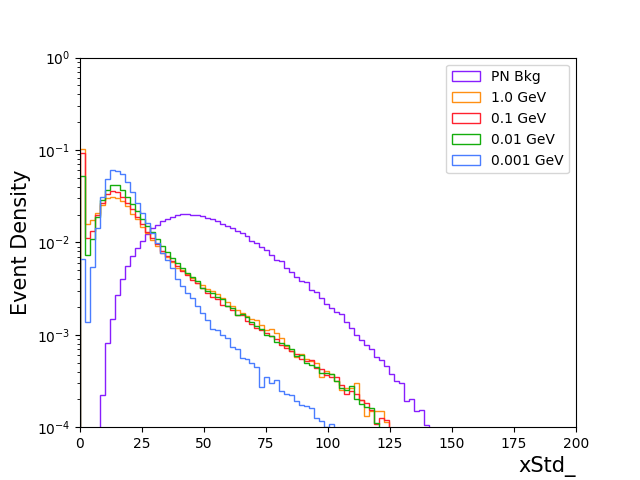

<IPython.core.display.Javascript object>


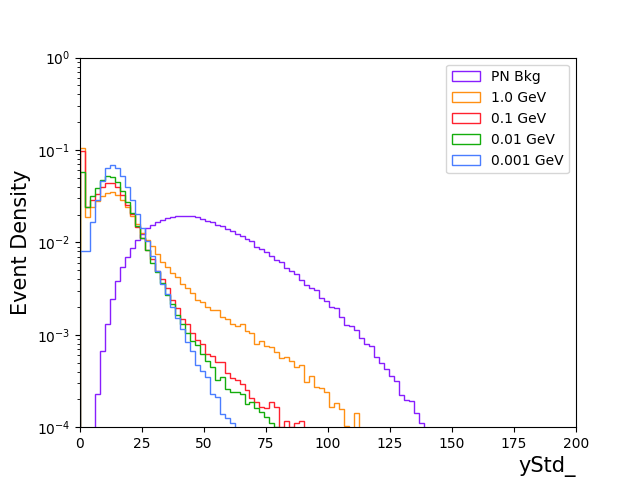

<IPython.core.display.Javascript object>


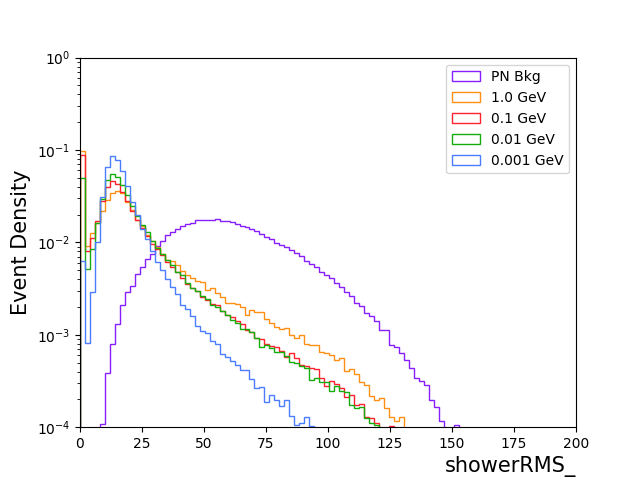

<IPython.core.display.Javascript object>


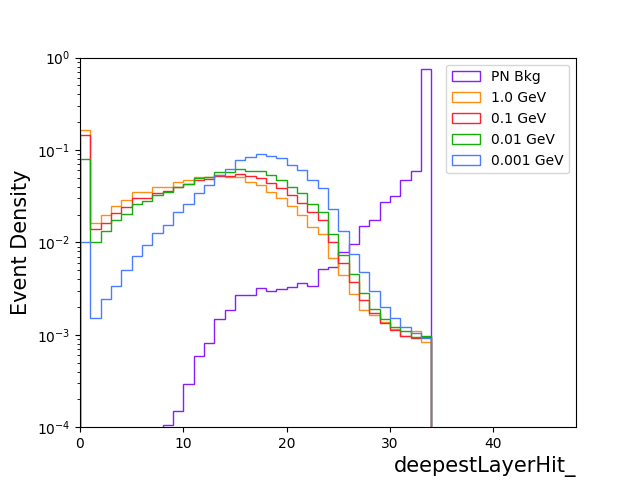

<IPython.core.display.Javascript object>


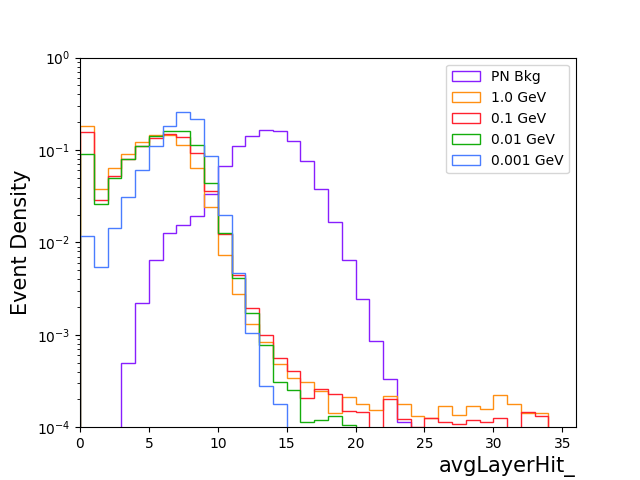

<IPython.core.display.Javascript object>


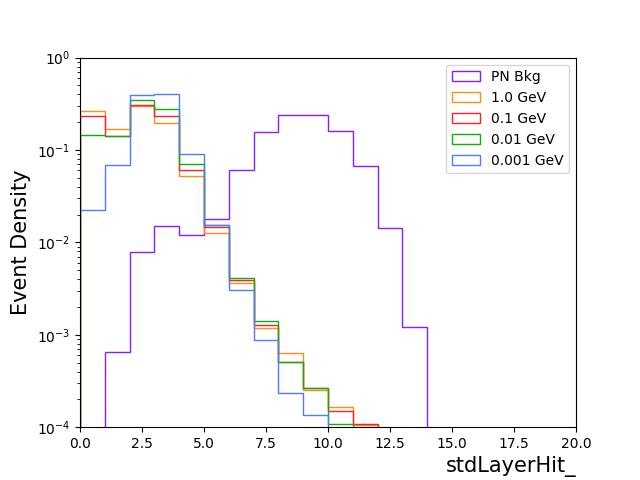

<IPython.core.display.Javascript object>


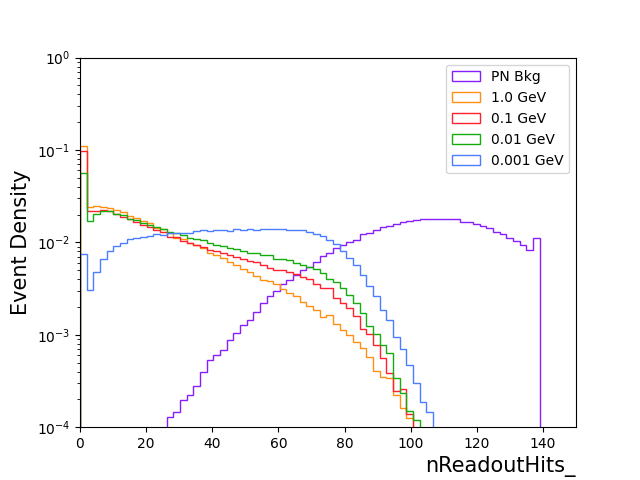

<IPython.core.display.Javascript object>


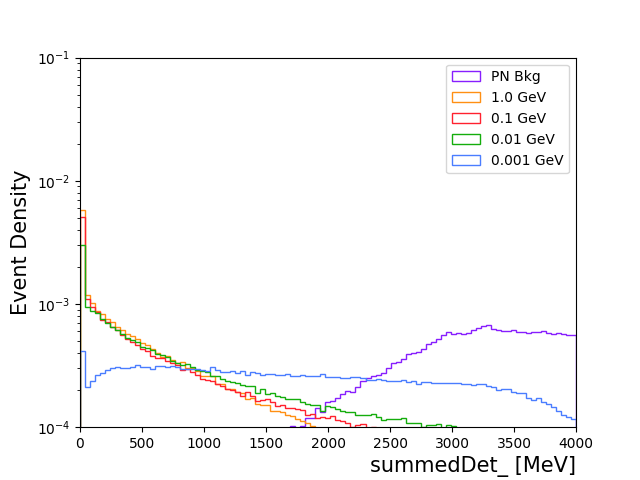

<IPython.core.display.Javascript object>


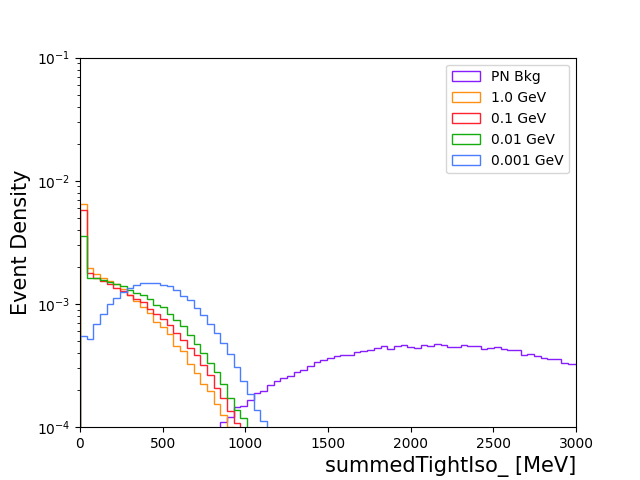

<IPython.core.display.Javascript object>


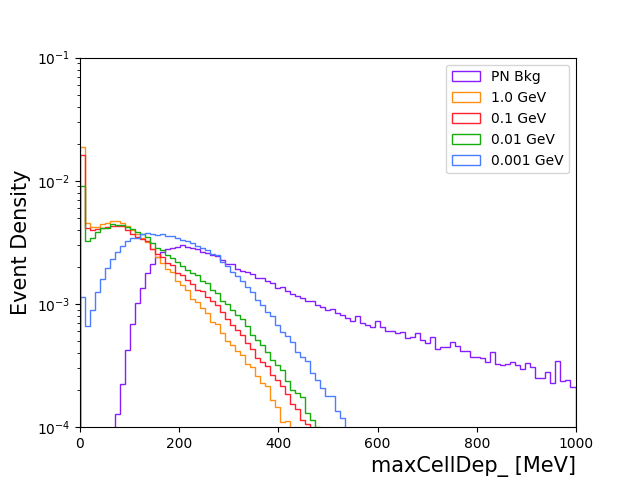

In [9]:
# plot histograms
import matplotlib.pyplot as plt

for var, data in plot_vars.items():
    fig, ax = plt.subplots()
    vals = [data[mass] for mass in file_templates.keys()]
    labels = [f'{mass} GeV' if mass else 'PN Bkg' for mass in file_templates.keys()]
    ax.hist(vals, bins=bin_dict[var], range=x_ranges[var], density=True, stacked=False, histtype='step', color=colors, 
            label=labels, log=log_dict[var])
    #ax.set_title(f'v14 {var}')
    ax.set_ylabel('Event Density', fontsize = 15)
    if units[var]:
        ax.set_xlabel(f'{var} [{units[var]}]', fontsize=15, ha='right', x=1.0)
    else:
        ax.set_xlabel(f'{var}', fontsize=15, ha='right', x=1.0)
    ax.legend()
    ax.set_xlim(x_ranges[var][0], x_ranges[var][1])
    if log_dict[var]:
        ax.set_ylim(y_ranges[var][0], y_ranges[var][1])
    #plt.tight_layout()
    #plt.savefig(f"v14_4gev_{var}", facecolor='w', dpi=250)